# Proyek Machine Learning Terapan: Sistem Rekomendasi Tempat Wisata
- **Nama:** Dita Ary Crystian
- **Email:** arycrystian01@gmail.com
- **ID Dicoding:** dita_ary_crystian

# Data Understanding

Pada langkah pertama, lakukan import library yang diperlukan untuk pengolahan dataset nantinya.

In [1]:
#import library
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from zipfile import ZipFile
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from pathlib import Path


import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

Pada langkah ini,  upload kaggle.json yang berisi username dan key dari akun kaggle pengguna.

In [5]:
# Import module yang disediakan google colab untuk kebutuhan upload file

from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"ditaarycrystian","key":"b9a727641d1ce3feb7d0b1fe248d894a"}'}

Setelah upload kaggle.json, download dataset dari kaggle, pada kasus ini yaitu dataset destinasi tempat wisata di indonesia, lalu ekstrak dataset itu, lalu  deskripsikan variabel untuk masing-masing data csv yang ada di dataset ini.

In [8]:
# Buat folder .kaggle dan pindahkan kaggle.json ke sana
!mkdir -p /root/.kaggle
!cp kaggle.json /root/.kaggle/
!chmod 600 /root/.kaggle/kaggle.json

# Cek sudah benar
!ls -l /root/.kaggle


total 4
-rw------- 1 root root 71 Apr 24 02:17 kaggle.json


In [9]:
#Download dataset
!kaggle datasets download -d aprabowo/indonesia-tourism-destination

Dataset URL: https://www.kaggle.com/datasets/aprabowo/indonesia-tourism-destination
License(s): copyright-authors


In [10]:
#ekstrak dataset yang telah didownload
!unzip indonesia-tourism-destination.zip

Archive:  indonesia-tourism-destination.zip
  inflating: package_tourism.csv     
  inflating: tourism_rating.csv      
  inflating: tourism_with_id.csv     
  inflating: user.csv                


In [11]:
#definisi variabel untuk masing-masing dataset
package_df = pd.read_csv('package_tourism.csv')
rating_df = pd.read_csv('tourism_rating.csv')
location_df = pd.read_csv('tourism_with_id.csv')
user_df = pd.read_csv('user.csv')

print('Banyaknya data package: ', len(package_df))
print('Banyaknya data rating: ', len(rating_df))
print('Banyaknya data location: ', len(location_df))
print('Banyaknya data user: ', len(user_df))

Banyaknya data package:  100
Banyaknya data rating:  10000
Banyaknya data location:  437
Banyaknya data user:  300


Terlihat bahwa dataset indonesia tourism destination memiliki 4 sub-dataset, yaitu untuk package, rating, location, serta user, dengan masing-masing banyaknya data yaitu 100 untuk package, 1000 untuk rating, 437 untuk location, dan 300 untuk user.

## Univariate EDA

Pada langkah ini, lakukan pengecekan banyaknya data dari masing-masing variabel serta beberapa nilai unik yang akan diidentifikasi.

### Dataset package

In [12]:
package_df.head()

,Package,City,Place_Tourism1,Place_Tourism2,Place_Tourism3,Place_Tourism4,Place_Tourism5
0,1,Jakarta,Pasar Tanah Abang,Taman Ayodya,Museum Tekstil,NaN,NaN
1,2,Jakarta,Pasar Tanah Abang,Pasar Taman Puring,Pasar Petak Sembilan,NaN,NaN
2,3,Jakarta,Perpustakaan Nasional,Monas,Masjid Istiqlal,NaN,NaN
3,4,Jakarta,Pulau Tidung,Pulau Bidadari,Pulau Pari,Pulau Pramuka,Pulau Pelangi
4,5,Jakarta,Museum Satria Mandala,Museum Wayang,Museum Bahari Jakarta,Museum Macan (Modern and Contemporary Art in N...,NaN


In [13]:
print('Banyak data: ', len(package_df['Package'].unique()))
print('Banyak Kota: ', package_df['City'].unique())

Banyak data:  100
Banyak Kota:  ['Jakarta' 'Yogyakarta' 'Bandung' 'Semarang' 'Surabaya']


In [14]:
package_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   Package         100 non-null    int64 
 1   City            100 non-null    object
 2   Place_Tourism1  100 non-null    object
 3   Place_Tourism2  100 non-null    object
 4   Place_Tourism3  100 non-null    object
 5   Place_Tourism4  66 non-null     object
 6   Place_Tourism5  39 non-null     object
dtypes: int64(1), object(6)
memory usage: 5.6+ KB


            jumlah sampel  persentase
City                                 
Jakarta                20        20.0
Yogyakarta             20        20.0
Bandung                20        20.0
Semarang               20        20.0
Surabaya               20        20.0


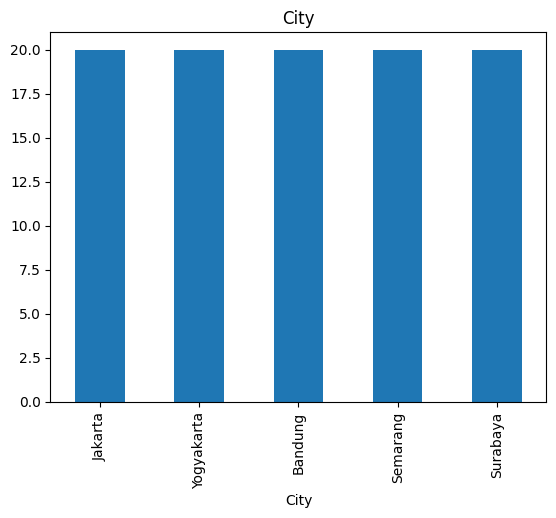

In [15]:
feature = 'City'
count = package_df[feature].value_counts()
percent = 100*package_df[feature].value_counts(normalize=True)

df_vis = pd.DataFrame({'jumlah sampel':count, 'persentase':percent.round(1)})
print(df_vis)
count.plot(kind='bar', title=feature);

Berikut merupakan penjelasan tiap variabel di dataset package:
- Package: ID unik untuk setiap paket wisata.
- City: Kota di mana tempat wisata berada.
- Place_Tourism1 : Destinasi wisata pertama yang termasuk dalam paket
- Place_Tourism2 : Destinasi wisata kedua yang termasuk dalam paket
- Place_Tourism3 : Destinasi wisata ketiga yang termasuk dalam paket
- Place_Tourism4 : Destinasi wisata keempat yang termasuk dalam paket
- Place_Tourism5 : Destinasi wisata kelima yang termasuk dalam paket

Terlihat bahwa dataset package memiliki 100 data dan 7 variabel, dengan ada nya nilai null pada variabel Place_tourism4 dan Place_tourism5. Selain itu, pada dataset ini memiliki 5 data unik untuk variabel City, yaitu Jakarta, Yogyakarta, Bandung, Semarang, Surabaya, dengan banyaknya data di tiap kota adalah 20 paket.

## Dataset Rating

In [16]:
rating_df.head()

,User_Id,Place_Id,Place_Ratings
0,1,179,3
1,1,344,2
2,1,5,5
3,1,373,3
4,1,101,4


In [17]:
print('Banyak user: ', len(rating_df['User_Id'].unique()))
print('Banyak rating: ', (rating_df['Place_Ratings'].unique()))

Banyak user:  300
Banyak rating:  [3 2 5 4 1]


In [18]:
rating_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype
---  ------         --------------  -----
 0   User_Id        10000 non-null  int64
 1   Place_Id       10000 non-null  int64
 2   Place_Ratings  10000 non-null  int64
dtypes: int64(3)
memory usage: 234.5 KB


               jumlah sampel  persentase
Place_Ratings                           
4                       2106        21.1
3                       2096        21.0
2                       2071        20.7
5                       2021        20.2
1                       1706        17.1


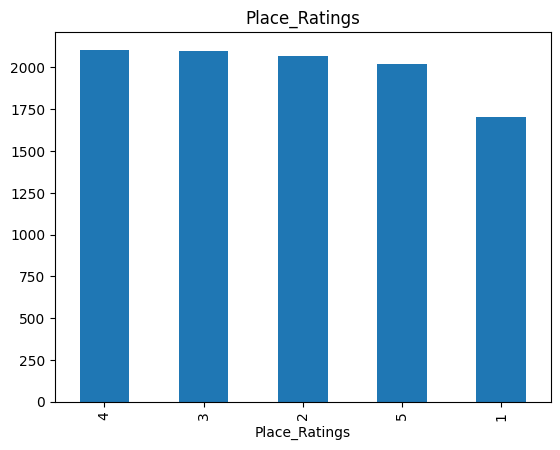

In [19]:
feature = 'Place_Ratings'
count = rating_df[feature].value_counts()
percent = 100*rating_df[feature].value_counts(normalize=True)

df_vis = pd.DataFrame({'jumlah sampel':count, 'persentase':percent.round(1)})
print(df_vis)
count.plot(kind='bar', title=feature);

Berikut merupakan penjelasan tiap variabel di dataset rating:
- User_Id        : ID unik untuk setiap user.
- Place_Id       : ID unik untuk setiap tempat wisata.
- Place_Ratings  : Rating untuk setiap tempat wisata dari user.

Terlihat bahwa dataset rating memiliki 10000 data dan 3 variabel. Pada dataset ini juga memiliki 300 nilai unik pada variabel User_Id dan 5 nilai unik pada Place_Ratings, dengan nilai 1,2,3,4,5, dengan rating 4 memiliki data paling banyak daripada rating lainnya dengan selisih yang tipis.

## Dataframe location

In [20]:
location_df.head()

,Place_Id,Place_Name,Description,Category,City,Price,Rating,Time_Minutes,Coordinate,Lat,Long,Unnamed: 11,Unnamed: 12
0,1,Monumen Nasional,Monumen Nasional atau yang populer disingkat d...,Budaya,Jakarta,20000,4.6,15.0,"{'lat': -6.1753924, 'lng': 106.8271528}",-6.175392,106.827153,NaN,1
1,2,Kota Tua,"Kota tua di Jakarta, yang juga bernama Kota Tu...",Budaya,Jakarta,0,4.6,90.0,"{'lat': -6.137644799999999, 'lng': 106.8171245}",-6.137645,106.817125,NaN,2
2,3,Dunia Fantasi,Dunia Fantasi atau disebut juga Dufan adalah t...,Taman Hiburan,Jakarta,270000,4.6,360.0,"{'lat': -6.125312399999999, 'lng': 106.8335377}",-6.125312,106.833538,NaN,3
3,4,Taman Mini Indonesia Indah (TMII),Taman Mini Indonesia Indah merupakan suatu kaw...,Taman Hiburan,Jakarta,10000,4.5,NaN,"{'lat': -6.302445899999999, 'lng': 106.8951559}",-6.302446,106.895156,NaN,4
4,5,Atlantis Water Adventure,Atlantis Water Adventure atau dikenal dengan A...,Taman Hiburan,Jakarta,94000,4.5,60.0,"{'lat': -6.12419, 'lng': 106.839134}",-6.124190,106.839134,NaN,5


In [21]:
print('Banyak tempat wisata: ', len(location_df['Place_Name'].unique()))
print('Tipe Kategori: ', location_df['Category'].unique())

Banyak tempat wisata:  437
Tipe Kategori:  ['Budaya' 'Taman Hiburan' 'Cagar Alam' 'Bahari' 'Pusat Perbelanjaan'
 'Tempat Ibadah']


In [22]:
location_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 437 entries, 0 to 436
Data columns (total 13 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Place_Id      437 non-null    int64  
 1   Place_Name    437 non-null    object 
 2   Description   437 non-null    object 
 3   Category      437 non-null    object 
 4   City          437 non-null    object 
 5   Price         437 non-null    int64  
 6   Rating        437 non-null    float64
 7   Time_Minutes  205 non-null    float64
 8   Coordinate    437 non-null    object 
 9   Lat           437 non-null    float64
 10  Long          437 non-null    float64
 11  Unnamed: 11   0 non-null      float64
 12  Unnamed: 12   437 non-null    int64  
dtypes: float64(5), int64(3), object(5)
memory usage: 44.5+ KB


                    jumlah sampel  persentase
Category                                     
Taman Hiburan                 135        30.9
Budaya                        117        26.8
Cagar Alam                    106        24.3
Bahari                         47        10.8
Tempat Ibadah                  17         3.9
Pusat Perbelanjaan             15         3.4


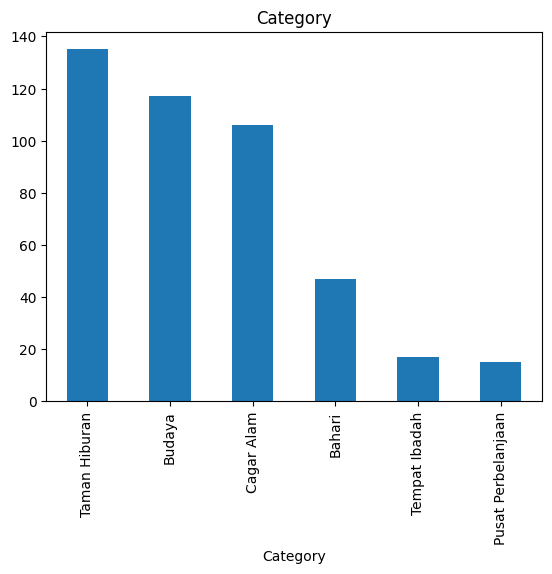

In [23]:
feature = 'Category'
count = location_df[feature].value_counts()
percent = 100*location_df[feature].value_counts(normalize=True)

df_vis = pd.DataFrame({'jumlah sampel':count, 'persentase':percent.round(1)})
print(df_vis)
count.plot(kind='bar', title=feature);

Berikut merupakan penjelasan tiap variabel di dataset location:
- Place_Id: ID unik untuk setiap tempat wisata.
- Place_Name: Nama tempat wisata.
- Description: Deskripsi singkat mengenai tempat wisata.
- Category: Kategori tempat wisata (misalnya, Budaya, Taman Hiburan, Cagar Alam).
- City: Kota di mana tempat wisata berada.
- Price: Harga tiket masuk ke tempat wisata (dalam rupiah).
- Rating: Penilaian rata-rata dari pengunjung (skala 1-5).
- Time_Minutes: Waktu yang diperlukan untuk mengunjungi tempat wisata (dalam menit).
- Coordinate: Koordinat geografis tempat wisata.
- Lat: Garis lintang lokasi tempat wisata.
- Long: Garis bujur lokasi tempat wisata.
- Unnamed: 11 : Tidak diketahui.
- Unnamed: 12 : Tidak diketahui.

Terlihat bahwa dataset location memiliki 437 data dan 13 variabel, dimana merupakan banyak nya data unik dari tempat wisata , dan adanya nilai null pada kolom Time_Minutes dan Unnamed: 11. Pada dataset ini memiliki 6 nilai unik pada kolom Category, yaitu Budaya, Taman Hiburan, Cagar Alam, Bahari, Pusat Perbelanjaan, Tempat Ibadah dan Taman hiburan memiliki data paling banyak dibandingkan kategori lain dengan 135 data.




## Dataset user

In [24]:
user_df.head()

,User_Id,Location,Age
0,1,"Semarang, Jawa Tengah",20
1,2,"Bekasi, Jawa Barat",21
2,3,"Cirebon, Jawa Barat",23
3,4,"Bekasi, Jawa Barat",21
4,5,"Lampung, Sumatera Selatan",20


In [25]:
print('Banyak user: ', len(user_df['User_Id'].unique()))
print('Lokasi user: ', len(user_df['Location'].unique()))

Banyak user:  300
Lokasi user:  28


In [26]:
user_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 300 entries, 0 to 299
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   User_Id   300 non-null    int64 
 1   Location  300 non-null    object
 2   Age       300 non-null    int64 
dtypes: int64(2), object(1)
memory usage: 7.2+ KB


In [27]:
user_df.describe()

,User_Id,Age
count,300.000000,300.000000
mean,150.500000,28.700000
std,86.746758,6.393716
min,1.000000,18.000000
25%,75.750000,24.000000
50%,150.500000,29.000000
75%,225.250000,34.000000
max,300.000000,40.000000


                           jumlah sampel  persentase
Location                                            
Bekasi, Jawa Barat                    39        13.0
Semarang, Jawa Tengah                 22         7.3
Lampung, Sumatera Selatan             20         6.7
Yogyakarta, DIY                       20         6.7
Bogor, Jawa Barat                     17         5.7


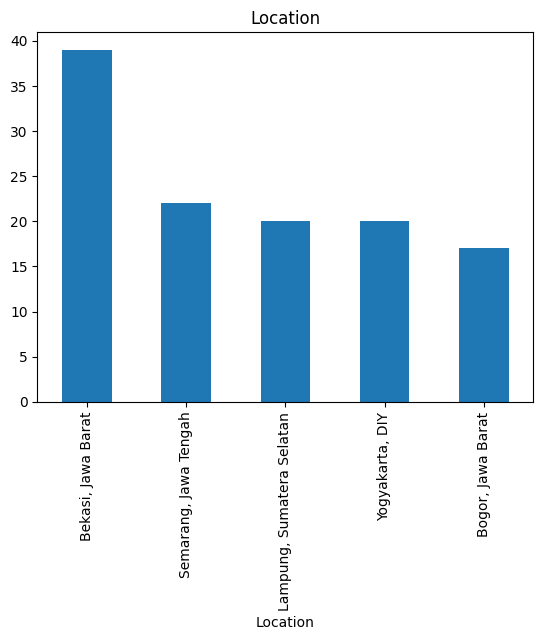

In [28]:
feature = 'Location'
count = user_df[feature].value_counts()
percent = 100*user_df[feature].value_counts(normalize=True)

top_5_count = count.head(5)
top_5_percent = percent.head(5)

df_vis = pd.DataFrame({'jumlah sampel':top_5_count, 'persentase':top_5_percent.round(1)})
print(df_vis)
top_5_count.plot(kind='bar', title=feature);

Berikut merupakan penjelasan tiap variabel di dataset user:
- User_Id: ID unik untuk setiap pengguna.
- Location: Kota atau lokasi asal pengguna.
- Age: Usia pengguna.

Terlihat bahwa dataset user memiliki 300 data dan 3 variabel, yang merupakan banyaknya nilai unik pada user. Pada dataset ini memiliki 28 nilai unik untuk asal daerah user, yaitu kolom Location. Selain itu dataset memiliki data di kolom Age, yaitu usia user, dengan rentang 24 sampai dengan 40 tahun. Serta 5 user pemberi rating terbanyak berada di Bekasi, Semarang, Yogyakarta, Lampung, dan Bogor.

#Data Preparation

##Preprocessing untuk EDA

### Mengecek total user dan location

Pada langkah ini, bagi 4 dataset menjadi 2 bagian, yaitu user dan location(tempat wisata). Setelah itu, gabungkan dataset rating_df dan user_df untuk mengetahui total dari user, serta gabungkan dataset location_df dan rating_df untuk mengetahui total dari location.

Pada langkah ini, gabungkan dataset dari user untuk mengetahui jumlah seluruh user yang ada.

In [29]:
# Menggabungkan seluruh userID
user_all = np.concatenate((
    rating_df['User_Id'].unique(),
    user_df['User_Id'].unique()
))

# Menghapus data yang sama kemudian mengurutkannya
user_all = np.sort(np.unique(user_all))

print('Jumlah seluruh user: ', len(user_all))

Jumlah seluruh user:  300


Terlihat bahwa jumlah seluruh user yaitu 300.

Setelah itu, gabungkan dataset dari location untuk mengetahui jumlah location  yang ada.

In [30]:
# Menggabungkan seluruh Place
place_all = np.concatenate((
    location_df['Place_Id'].unique(),
    rating_df['Place_Id'].unique()
))

# Menghapus data yang sama kemudian mengurutkannya
place_all = np.sort(np.unique(place_all))

print('Jumlah seluruh lokasi: ', len(place_all))

Jumlah seluruh lokasi:  437


Terlihat bahwa jumlah location yaitu 437 data.

### Mengecek jumlah rating

Selanjutnya, buat variabel baru, yaitu place, dengan menggabungkan data rating dan place untuk melihat banyaknya rating dari gabungan data yang ada, pada kasus ini data rating_df dan location_df

In [31]:
place = pd.merge(rating_df, location_df , on='Place_Id', how='left')
place

,User_Id,Place_Id,Place_Ratings,Place_Name,Description,Category,City,Price,Rating,Time_Minutes,Coordinate,Lat,Long,Unnamed: 11,Unnamed: 12
0,1,179,3,Candi Ratu Boko,Situs Ratu Baka atau Candi Boko (Hanacaraka:ꦕꦤ...,Budaya,Yogyakarta,75000,4.6,90.0,"{'lat': -7.7705416, 'lng': 110.4894158}",-7.770542,110.489416,NaN,179
1,1,344,2,Pantai Marina,"Pantai Marina (bahasa Jawa: ꦥꦱꦶꦱꦶꦂ​ꦩꦫꦶꦤ, trans...",Bahari,Semarang,3000,4.1,NaN,"{'lat': -6.948877, 'lng': 110.3893285}",-6.948877,110.389329,NaN,344
2,1,5,5,Atlantis Water Adventure,Atlantis Water Adventure atau dikenal dengan A...,Taman Hiburan,Jakarta,94000,4.5,60.0,"{'lat': -6.12419, 'lng': 106.839134}",-6.124190,106.839134,NaN,5
3,1,373,3,Museum Kereta Ambarawa,Museum Kereta Api Ambarawa (bahasa Inggris: In...,Budaya,Semarang,10000,4.5,60.0,"{'lat': -7.264598899999997, 'lng': 110.4046017}",-7.264599,110.404602,NaN,373
4,1,101,4,Kampung Wisata Sosro Menduran,Kampung wisata Sosromenduran merupakan kampung...,Budaya,Yogyakarta,0,4.0,NaN,"{'lat': -7.792189999999999, 'lng': 110.362151}",-7.792190,110.362151,NaN,101
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,300,425,2,Waterpark Kenjeran Surabaya,Waterpark Kenjeran Surabaya merupakan wisata k...,Taman Hiburan,Surabaya,35000,4.1,NaN,"{'lat': -7.247796300000002, 'lng': 112.7998235}",-7.247796,112.799824,NaN,425
9996,300,64,4,Museum Sasmita Loka Ahmad Yani,Museum Sasmita Loka Ahmad Yani adalah salah sa...,Budaya,Jakarta,2000,4.7,45.0,"{'lat': -6.204630300000001, 'lng': 106.8365324}",-6.204630,106.836532,NaN,64
9997,300,311,3,The Lodge Maribaya,The Lodge Maribaya adalah salah satu tempat wi...,Cagar Alam,Bandung,25000,4.3,150.0,"{'lat': -6.829411199999999, 'lng': 107.6874666}",-6.829411,107.687467,NaN,311
9998,300,279,4,Masjid Agung Trans Studio Bandung,Masjid Agung Trans Studio Bandung (TSB) berdir...,Tempat Ibadah,Bandung,0,4.8,NaN,"{'lat': -6.925963500000001, 'lng': 107.6354278}",-6.925963,107.635428,NaN,279


In [32]:
place.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 15 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   User_Id        10000 non-null  int64  
 1   Place_Id       10000 non-null  int64  
 2   Place_Ratings  10000 non-null  int64  
 3   Place_Name     10000 non-null  object 
 4   Description    10000 non-null  object 
 5   Category       10000 non-null  object 
 6   City           10000 non-null  object 
 7   Price          10000 non-null  int64  
 8   Rating         10000 non-null  float64
 9   Time_Minutes   4628 non-null   float64
 10  Coordinate     10000 non-null  object 
 11  Lat            10000 non-null  float64
 12  Long           10000 non-null  float64
 13  Unnamed: 11    0 non-null      float64
 14  Unnamed: 12    10000 non-null  int64  
dtypes: float64(5), int64(5), object(5)
memory usage: 1.1+ MB


In [33]:
place.isnull().sum()

,0
User_Id,0
Place_Id,0
Place_Ratings,0
Place_Name,0
Description,0
Category,0
City,0
Price,0
Rating,0
Time_Minutes,5372


Terlihat bahwa ada 10000 data rating yang berasal dari gabungan dataset rating_df dan location_df, serta data ini memiliki nilai null pada kolom time_minutes dan Unnamed: 11.

Setelah itu, ambil fitur numerik terlebih dahulu, lalu cari jumlah dari fitur numerik tersebut berdasarkan Place-Id.

In [34]:
# Pilih hanya kolom numerik
numerical_data = place.select_dtypes(include='number')

# Groupby 'Place-ID' dan hitung jumlahnya
result = numerical_data.groupby(place['Place_Id']).sum()
print(result)

          User_Id  Place_Id  Place_Ratings    Price  Rating  Time_Minutes  \
Place_Id                                                                    
1            2635        18             67   360000    82.8         270.0   
2            3260        50             71        0   115.0        2250.0   
3            3718        57             48  5130000    87.4        6840.0   
4            2708        84             60   210000    94.5           0.0   
5            3008       125             88  2350000   112.5        1500.0   
...           ...       ...            ...      ...     ...           ...   
433          3110      9959             76    46000   101.2        1035.0   
434          3419     10850             60        0   115.0           0.0   
435          2656      7395             51        0    74.8         765.0   
436          3810      9592             68        0   101.2           0.0   
437          6340     16606            125   380000   182.4           0.0   

## Data Preprocessing untuk *Content Based Filtering*



###Membuat dataframe untuk Modeling Content Based Filtering

Setelah itu, buat variabel baru, yaitu  all_place_name yang akan memuat data rating_df dan akan digabungkan dengan kolom Place_Id, Place_Name,
Category, City dari dataset location_df berdasarkan Place-Id.

In [35]:
all_place_name = rating_df
all_place_name

,User_Id,Place_Id,Place_Ratings
0,1,179,3
1,1,344,2
2,1,5,5
3,1,373,3
4,1,101,4
...,...,...,...
9995,300,425,2
9996,300,64,4
9997,300,311,3
9998,300,279,4


In [36]:
# Menggabungkan all resto_rate dengan dataframe geo berdasarkan placeID
all_place_name = pd.merge(all_place_name, location_df[['Place_Id','Place_Name', 'Category', 'City']], on='Place_Id', how='left')

# Print dataframe all_resto_name
all_place_name

,User_Id,Place_Id,Place_Ratings,Place_Name,Category,City
0,1,179,3,Candi Ratu Boko,Budaya,Yogyakarta
1,1,344,2,Pantai Marina,Bahari,Semarang
2,1,5,5,Atlantis Water Adventure,Taman Hiburan,Jakarta
3,1,373,3,Museum Kereta Ambarawa,Budaya,Semarang
4,1,101,4,Kampung Wisata Sosro Menduran,Budaya,Yogyakarta
...,...,...,...,...,...,...
9995,300,425,2,Waterpark Kenjeran Surabaya,Taman Hiburan,Surabaya
9996,300,64,4,Museum Sasmita Loka Ahmad Yani,Budaya,Jakarta
9997,300,311,3,The Lodge Maribaya,Cagar Alam,Bandung
9998,300,279,4,Masjid Agung Trans Studio Bandung,Tempat Ibadah,Bandung


###Mengecek nilai null

Setelah itu, cek nilai null, deskripsi analisis untuk fitur numerik, dan melihat banyaknya data unik dari kolom Place_Id, Place_Name, dan Category

In [37]:
all_place_name.isnull().sum()

,0
User_Id,0
Place_Id,0
Place_Ratings,0
Place_Name,0
Category,0
City,0


###Mengecek data duplikat

Setelah itu, cek nilai duplikat dari data tersebut.

In [38]:
duplicate_rows = all_place_name.duplicated()

print(duplicate_rows.sum())

79


Karena ada duplikat data, hapus data duplikat tersebut

In [39]:
all_place_name = all_place_name.drop_duplicates()

###Mengecek deskripsi analisis dan banyaknya data unik

Pada tahap ini, akan dilakukan pengecekan deskripsi analisis dan banyaknya data unik pada kolom Place_Id, Place_Name, dan Location.

In [40]:
all_place_name.describe()

,User_Id,Place_Id,Place_Ratings
count,9921.000000,9921.000000,9921.000000
mean,151.337970,219.486745,3.066929
std,86.107089,126.164097,1.380070
min,1.000000,1.000000,1.000000
25%,77.000000,109.000000,2.000000
50%,151.000000,220.000000,3.000000
75%,226.000000,329.000000,4.000000
max,300.000000,437.000000,5.000000


In [41]:
len(all_place_name['Place_Id'].unique())

437

In [42]:
len(all_place_name['Place_Name'].unique())

437

In [43]:
len(all_place_name['Category'].unique())

6

Bisa terlihat bahwa data sudah bersih dari nilai null, dan data memiliki 437 nilai unik pada Place_Id, 437 nilai unik pada Place_Name, dan 6 data unik pada Category, Selain itu, data memiliki 300 user dan rentang rating dari 1,2,3,4,5.

###mengecek kembali data untuk Content Based Filtering

Pada langkah ini, cek kembali data yang telah di preprocessing di langkah sebelumnya. Setelah itu, urutkan data terlebih dahulu berdasarkan Place_Id

In [44]:
all_place_name = all_place_name.sort_values('Place_Id', ascending=True)
all_place_name

,User_Id,Place_Id,Place_Ratings,Place_Name,Category,City
8426,254,1,5,Monumen Nasional,Budaya,Jakarta
1145,36,1,4,Monumen Nasional,Budaya,Jakarta
3417,105,1,5,Monumen Nasional,Budaya,Jakarta
1203,38,1,2,Monumen Nasional,Budaya,Jakarta
7552,227,1,5,Monumen Nasional,Budaya,Jakarta
...,...,...,...,...,...,...
2043,63,437,4,Gereja Perawan Maria Tak Berdosa Surabaya,Tempat Ibadah,Surabaya
9888,297,437,4,Gereja Perawan Maria Tak Berdosa Surabaya,Tempat Ibadah,Surabaya
4222,129,437,4,Gereja Perawan Maria Tak Berdosa Surabaya,Tempat Ibadah,Surabaya
47,2,437,4,Gereja Perawan Maria Tak Berdosa Surabaya,Tempat Ibadah,Surabaya


###mengecek nilai unik dari kolom Category

Setelah itu, cek nilai unik dari kolom Category untuk mengecek apakah ada kategori tempat wisata.

In [45]:
all_place_name['Category'].unique()

array(['Budaya', 'Taman Hiburan', 'Cagar Alam', 'Bahari',
       'Pusat Perbelanjaan', 'Tempat Ibadah'], dtype=object)

Terlihat bahwa data mempunyai kategori tempat wisata yaitu Budaya, Taman Hiburan, Cagar Alam, Pusat Perbelanjaan, dan Tempat Ibadah

###Menghapus duplikat pada Place_Id

Setelah itu, buat variabel preparation yang berisi data all_place_name. Lalu urutkan data berdasarkan Place_Id.

In [46]:
preparation = all_place_name
preparation.sort_values('Place_Id')

,User_Id,Place_Id,Place_Ratings,Place_Name,Category,City
8426,254,1,5,Monumen Nasional,Budaya,Jakarta
3862,118,1,4,Monumen Nasional,Budaya,Jakarta
2804,86,1,4,Monumen Nasional,Budaya,Jakarta
8785,265,1,4,Monumen Nasional,Budaya,Jakarta
5348,162,1,5,Monumen Nasional,Budaya,Jakarta
...,...,...,...,...,...,...
1986,61,437,5,Gereja Perawan Maria Tak Berdosa Surabaya,Tempat Ibadah,Surabaya
4222,129,437,4,Gereja Perawan Maria Tak Berdosa Surabaya,Tempat Ibadah,Surabaya
47,2,437,4,Gereja Perawan Maria Tak Berdosa Surabaya,Tempat Ibadah,Surabaya
42,2,437,5,Gereja Perawan Maria Tak Berdosa Surabaya,Tempat Ibadah,Surabaya


Lalu hapus nilai duplikat dari Place_Id karena  hanya menggunakan data unik dari data yang ada.

In [47]:
preparation = preparation.drop_duplicates('Place_Id')
preparation

,User_Id,Place_Id,Place_Ratings,Place_Name,Category,City
8426,254,1,5,Monumen Nasional,Budaya,Jakarta
1837,57,2,4,Kota Tua,Budaya,Jakarta
6156,185,3,1,Dunia Fantasi,Taman Hiburan,Jakarta
127,5,4,3,Taman Mini Indonesia Indah (TMII),Taman Hiburan,Jakarta
7924,238,5,2,Atlantis Water Adventure,Taman Hiburan,Jakarta
...,...,...,...,...,...,...
1096,34,433,4,Museum Mpu Tantular,Budaya,Surabaya
123,5,434,4,Taman Bungkul,Taman Hiburan,Surabaya
6013,181,435,2,Taman Air Mancur Menari Kenjeran,Taman Hiburan,Surabaya
5674,171,436,4,Taman Flora Bratang Surabaya,Taman Hiburan,Surabaya


###Membuat data dictionary untuk modeling

Setelah itu, konversi data series menjadi list, sehingga gunakan fungsi *tolist* untuk konversi data.

In [48]:
# Mengonversi data series ‘placeID’ menjadi dalam bentuk list
place_id = preparation['Place_Id'].tolist()

# Mengonversi data series ‘Name’ menjadi dalam bentuk list
place_name = preparation['Place_Name'].tolist()

# Mengonversi data series ‘Rcuisine’ menjadi dalam bentuk list
place_cat = preparation['Category'].tolist()

print(len(place_id))
print(len(place_name))
print(len(place_cat))

437
437
437


Setelah itu, buat data dictionary untuk data place_id, place_name, dan place_cat(place_category). Lalu cek data yang telah dibuat.

In [49]:
place_new = pd.DataFrame({
    'id': place_id,
    'name': place_name,
    'category': place_cat
})

place_new

,id,name,category
0,1,Monumen Nasional,Budaya
1,2,Kota Tua,Budaya
2,3,Dunia Fantasi,Taman Hiburan
3,4,Taman Mini Indonesia Indah (TMII),Taman Hiburan
4,5,Atlantis Water Adventure,Taman Hiburan
...,...,...,...
432,433,Museum Mpu Tantular,Budaya
433,434,Taman Bungkul,Taman Hiburan
434,435,Taman Air Mancur Menari Kenjeran,Taman Hiburan
435,436,Taman Flora Bratang Surabaya,Taman Hiburan


### Ekstraksi TF-IDF

Pada langkah ini, buat variabel data yang berisi data place_new.

In [50]:
data = place_new
data.head()

,id,name,category
0,1,Monumen Nasional,Budaya
1,2,Kota Tua,Budaya
2,3,Dunia Fantasi,Taman Hiburan
3,4,Taman Mini Indonesia Indah (TMII),Taman Hiburan
4,5,Atlantis Water Adventure,Taman Hiburan


Setelah itu, panggil fungsi TfidfVectorizer lalu  fit dengan kolom Category.

In [51]:
# Inisialisasi TfidfVectorizer
tf = TfidfVectorizer()

# Melakukan perhitungan idf pada data cuisine
tf.fit(data['category'])

# Mapping array dari fitur index integer ke fitur nama
tf.get_feature_names_out()

array(['alam', 'bahari', 'budaya', 'cagar', 'hiburan', 'ibadah',
       'perbelanjaan', 'pusat', 'taman', 'tempat'], dtype=object)

Kemudian lakukan fit transform dan melihat ukuran matrix setelah dilakukan fit transform TF-IDF

In [52]:
tfidf_matrix = tf.fit_transform(data['category'])

# Melihat ukuran matrix tfidf
tfidf_matrix.shape

(437, 10)

Kemudian lihat data dalam bentuk matrix, namun sebelum itu, gunakan fungsi todense untuk menghasilkan vektor TF-IDF dalam bentuk matrix.

In [53]:
# Mengubah vektor tf-idf dalam bentuk matriks dengan fungsi todense()
tfidf_matrix.todense()

matrix([[0.        , 0.        , 1.        , ..., 0.        , 0.        ,
         0.        ],
        [0.        , 0.        , 1.        , ..., 0.        , 0.        ,
         0.        ],
        [0.        , 0.        , 0.        , ..., 0.        , 0.70710678,
         0.        ],
        ...,
        [0.        , 0.        , 0.        , ..., 0.        , 0.70710678,
         0.        ],
        [0.        , 0.        , 0.        , ..., 0.        , 0.70710678,
         0.        ],
        [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.70710678]])

Setelah itu, lihat hasil dari TF-IDF dibawah ini.

In [54]:
pd.DataFrame(
    tfidf_matrix.todense(),
    columns=tf.get_feature_names_out(),
    index=data.name
).sample(10, axis=1).sample(10, axis=0)

,cagar,taman,perbelanjaan,budaya,hiburan,pusat,ibadah,tempat,bahari,alam
name,,,,,,,,,,
Taman Lapangan Banteng,0.0,0.707107,0.0,0.0,0.707107,0.0,0.0,0.0,0.0,0.0
Taman Ekspresi Dan Perpustakaan,0.0,0.707107,0.0,0.0,0.707107,0.0,0.0,0.0,0.0,0.0
Skyrink - Mall Taman Anggrek,0.0,0.707107,0.0,0.0,0.707107,0.0,0.0,0.0,0.0,0.0
Museum Perangko,0.0,0.000000,0.0,1.0,0.000000,0.0,0.0,0.0,0.0,0.0
Taman Vanda,0.0,0.707107,0.0,0.0,0.707107,0.0,0.0,0.0,0.0,0.0
Pantai Baron,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,1.0,0.0
Jakarta Planetarium,0.0,0.707107,0.0,0.0,0.707107,0.0,0.0,0.0,0.0,0.0
Desa Wisata Rumah Domes/Teletubbies,0.0,0.707107,0.0,0.0,0.707107,0.0,0.0,0.0,0.0,0.0
Waterboom PIK (Pantai Indah Kapuk),0.0,0.707107,0.0,0.0,0.707107,0.0,0.0,0.0,0.0,0.0


Bisa terlihat bahwa Museum Perangko memiliki nilai 1 pada kolom budaya, sehingga Museum Perangko termasuk ke dalam kategori budaya, dan sebagainya.

##Data Preprocessing untuk Collaborative Filtering

###Membuat dataframe untuk Modeling Collaborative Filtering

Pada bagian ini, langkah pertama yaitu buat variabel df yang memuat dataset rating_df.

In [55]:
df = rating_df
df

,User_Id,Place_Id,Place_Ratings
0,1,179,3
1,1,344,2
2,1,5,5
3,1,373,3
4,1,101,4
...,...,...,...
9995,300,425,2
9996,300,64,4
9997,300,311,3
9998,300,279,4


Setelah itu, lakukan persiapan data untuk menyandikan (encode) fitur User_Id ke dalam indeks integer.

In [56]:
# Mengubah userID menjadi list tanpa nilai yang sama
user_ids = df['User_Id'].unique().tolist()
print('list userID: ', user_ids)

# Melakukan encoding userID
user_to_user_encoded = {x: i for i, x in enumerate(user_ids)}
print('encoded userID : ', user_to_user_encoded)

# Melakukan proses encoding angka ke ke userID
user_encoded_to_user = {i: x for i, x in enumerate(user_ids)}
print('encoded angka ke userID: ', user_encoded_to_user)

list userID:  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219

Setelah itu, lakukan persiapan data untuk menyandikan (encode) fitur Place_Id ke dalam indeks integer.

In [57]:
# Mengubah placeID menjadi list tanpa nilai yang sama
place_ids = df['Place_Id'].unique().tolist()

# Melakukan proses encoding placeID
place_to_place_encoded = {x: i for i, x in enumerate(place_ids)}

# Melakukan proses encoding angka ke placeID
place_encoded_to_place = {i: x for i, x in enumerate(place_ids)}

Berikutnya, petakan userID dan placeID ke dataframe yang berkaitan.

In [58]:
# Mapping userID ke dataframe user
df['user'] = df['User_Id'].map(user_to_user_encoded)

# Mapping placeID ke dataframe place
df['place'] = df['Place_Id'].map(place_to_place_encoded)

Setelah itu, cek beberapa hal dalam data seperti jumlah user, jumlah tempat wisata, dan mengubah nilai rating menjadi float.

In [59]:
# Mendapatkan jumlah user
num_users = len(user_to_user_encoded)
print(num_users)

# Mendapatkan jumlah place
num_place = len(place_encoded_to_place)
print(num_place)

# Mengubah rating menjadi nilai float
df['Place_Ratings'] = df['Place_Ratings'].values.astype(np.float32)

# Nilai minimum rating
min_rating = min(df['Place_Ratings'])

# Nilai maksimal rating
max_rating = max(df['Place_Ratings'])

print('Number of User: {}, Number of place: {}, Min Rating: {}, Max Rating: {}'.format(
    num_users, num_place, min_rating, max_rating
))

300
437
Number of User: 300, Number of place: 437, Min Rating: 1.0, Max Rating: 5.0


Terlihat bahwa dataframe memiliki data user sebanyak 300 data, data place sebanyak 437 data, serta data rating dari 1.0 sampai 5.0.

###Acak data

Setelah itu, acak datanya terlebih dahulu agar distribusinya menjadi random.

In [60]:
df = df.sample(frac=1, random_state=42)
df

,User_Id,Place_Id,Place_Ratings,user,place
6252,188,207,3.0,187,262
4684,142,268,2.0,141,83
1731,54,103,3.0,53,10
4742,144,119,3.0,143,141
4521,138,288,5.0,137,283
...,...,...,...,...,...
5734,173,402,5.0,172,175
5191,157,85,4.0,156,33
5390,163,18,3.0,162,52
860,28,416,4.0,27,187


Karena pada kolom user tidak terjadi pengacakan, maka acak kolom user terlebih dahulu.

In [61]:
df['user'] = np.random.permutation(df['user'].values)
df

,User_Id,Place_Id,Place_Ratings,user,place
6252,188,207,3.0,202,262
4684,142,268,2.0,135,83
1731,54,103,3.0,57,10
4742,144,119,3.0,262,141
4521,138,288,5.0,195,283
...,...,...,...,...,...
5734,173,402,5.0,7,175
5191,157,85,4.0,241,33
5390,163,18,3.0,208,52
860,28,416,4.0,148,187


###Membagi data train dan data validation

Selanjutnya, bagi data train dan validasi dengan komposisi 80:20 dari data yang sudah disiapkan di proses data preparation. Namun sebelumnya, petakan (mapping) data user dan place menjadi satu value terlebih dahulu. Lalu, buatlah rating dalam skala 0 sampai 1 agar mudah dalam melakukan proses training.

In [69]:
# Membuat variabel x untuk mencocokkan data user dan resto menjadi satu value
x = df[['user', 'place']].values

# Membuat variabel y untuk membuat rating dari hasil
y = df['Place_Ratings'].apply(lambda x: (x - min_rating) / (max_rating - min_rating)).values

# Membagi menjadi 80% data train dan 20% data validasi
train_indices = int(0.8 * df.shape[0])
x_train, x_val, y_train, y_val = (
    x[:train_indices],
    x[train_indices:],
    y[:train_indices],
    y[train_indices:]
)

print(x, y)

[[202 262]
 [135  83]
 [ 57  10]
 ...
 [208  52]
 [148 187]
 [ 88   6]] [0.5  0.25 0.5  ... 0.5  0.75 0.25]


# Modeling

## Content Based Filtering

### Cosine Similarity

Selanjutnya, hitung derajat kesamaan (similarity degree) antar tempat wisata dengan teknik cosine similarity

In [62]:
# Menghitung cosine similarity pada matrix tf-idf
cosine_sim = cosine_similarity(tfidf_matrix)
cosine_sim

array([[1., 1., 0., ..., 0., 0., 0.],
       [1., 1., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 1., 1., 0.],
       ...,
       [0., 0., 1., ..., 1., 1., 0.],
       [0., 0., 1., ..., 1., 1., 0.],
       [0., 0., 0., ..., 0., 0., 1.]])

Selanjutnya, lihat matriks kesamaan setiap tempat wisata dengan menampilkan nama tempat wisata dalam 5 sampel kolom (axis = 1) dan 10 sampel baris (axis=0).

In [63]:
cosine_sim_df = pd.DataFrame(cosine_sim, index=data['name'], columns=data['name'])
print('Shape:', cosine_sim_df.shape)

# Melihat similarity matrix pada setiap lokasi
cosine_sim_df.sample(5, axis=1).sample(10, axis=0)

Shape: (437, 437)


name,Pantai Greweng,Taman Suropati,Bumi Perkemahan Batu Kuda,Umbul Sidomukti,Kampoeng Djadhoel Semarang
name,,,,,
Kauman Pakualaman Yogyakarta,0.0,0.0,0.0,0.0,1.0
Candi Ratu Boko,0.0,0.0,0.0,0.0,1.0
Puncak Kebun Buah Mangunan,0.0,1.0,0.0,0.0,0.0
Museum Gunung Merapi,0.0,0.0,0.0,0.0,1.0
Pantai Ancol,1.0,0.0,0.0,0.0,0.0
Curug Cipanas,0.0,0.0,1.0,1.0,0.0
Museum Taman Prasasti,0.0,0.0,0.0,0.0,1.0
Tektona Waterpark,0.0,1.0,0.0,0.0,0.0
Museum Geologi Bandung,0.0,0.0,0.0,0.0,1.0


Pada contohnya, bisa terlihat bahwa Curug Cipanas memiliki angka 1 dengan Bumi Perkemahan Batu Kuda dan Umbul Sidomukti. Ini berarti bahwa Curug Cipanas memiliki kategori yang sama dengan Bumi Perkemahan Batu Kuda dan Umbul Sidomukti.

### Modeling Content Based Filtering

Setelah itu, buat fungsi untuk mendapatkan rekomendasi tempat wisata dengan data yang sudah disiapkan sebelumnya di proses data preparation. Pada fungsi ini, buat fungsi untuk mendapatkan 5 rekomendasi tempat wisata dengan nama yang diinputkan nanti.

In [65]:
def location_recommendations(nama, similarity_data=cosine_sim_df, items=data[['name', 'category']], k=5):
    """
    Rekomendasi Resto berdasarkan kemiripan dataframe

    Parameter:
    ---
    nama : tipe data string (str)
                Nama Tempat Wisata (index kemiripan dataframe)
    similarity_data : tipe data pd.DataFrame (object)
                      Kesamaan dataframe, simetrik, dengan resto sebagai
                      indeks dan kolom
    items : tipe data pd.DataFrame (object)
            Mengandung kedua nama dan fitur lainnya yang digunakan untuk mendefinisikan kemiripan
    k : tipe data integer (int)
        Banyaknya jumlah rekomendasi yang diberikan
    ---


    Pada index ini akan diambil k dengan nilai similarity terbesar
    pada index matrix yang diberikan (i).
    """


    # Mengambil data dengan menggunakan argpartition untuk melakukan partisi secara tidak langsung sepanjang sumbu yang diberikan
    # Dataframe diubah menjadi numpy
    # Range(start, stop, step)
    index = similarity_data.loc[:,nama].to_numpy().argpartition(
        range(-1, -k, -1))

    # Mengambil data dengan similarity terbesar dari index yang ada
    closest = similarity_data.columns[index[-1:-(k+2):-1]]

    # Drop nama_resto agar nama resto yang dicari tidak muncul dalam daftar rekomendasi
    closest = closest.drop(nama, errors='ignore')

    return pd.DataFrame(closest).merge(items).head(k)

Setelah itu, masukkan data yang akan dicari rekomendasi nya.

In [66]:
data[data.name.eq('Kebun Binatang Ragunan')]

,id,name,category
6,7,Kebun Binatang Ragunan,Cagar Alam


Kemudian, cari rekomendasi nya dengan fungsi yang telah dibuat sebelumnya.

In [67]:
location_recommendations('Kebun Binatang Ragunan')

,name,category
0,Tebing Karaton,Cagar Alam
1,Situ Cileunca,Cagar Alam
2,Lereng Anteng Panoramic Coffee Place,Cagar Alam
3,Sunrise Point Cukul,Cagar Alam
4,The Lodge Maribaya,Cagar Alam


Terlihat bahwa fungsi merekomendasikan tempat wisata dengan category yang sama.  



## Model Development dengan Collaborative Filtering

### Collaborative Filtering Modeling

In [68]:
# Import library
import pandas as pd
import numpy as np
from zipfile import ZipFile
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from pathlib import Path
import matplotlib.pyplot as plt

Setelah itu, buat class RecommenderNet dengan keras Model class.

In [70]:
class RecommenderNet(tf.keras.Model):

  # Insialisasi fungsi
  def __init__(self, num_users, num_place, embedding_size, **kwargs):
    super(RecommenderNet, self).__init__(**kwargs)
    self.num_users = num_users
    self.num_place = num_place
    self.embedding_size = embedding_size
    self.user_embedding = layers.Embedding( # layer embedding user
        num_users,
        embedding_size,
        embeddings_initializer = 'he_normal',
        embeddings_regularizer = keras.regularizers.l2(1e-4)
    )
    self.user_bias = layers.Embedding(num_users, 1) # layer embedding user bias
    self.place_embedding = layers.Embedding( # layer embeddings place
        num_place,
        embedding_size,
        embeddings_initializer = 'he_normal',
        embeddings_regularizer = keras.regularizers.l2(1e-6)
    )
    self.place_bias = layers.Embedding(num_place, 1) # layer embedding place bias

    self.dropout = layers.Dropout(0.3)

  def call(self, inputs):
    user_vector = self.user_embedding(inputs[:,0]) # memanggil layer embedding 1
    user_vector = self.dropout(user_vector)
    user_bias = self.user_bias(inputs[:, 0]) # memanggil layer embedding 2
    place_vector = self.place_embedding(inputs[:, 1]) # memanggil layer embedding 3
    place_vector = self.dropout(place_vector)
    place_bias = self.place_bias(inputs[:, 1]) # memanggil layer embedding 4

    dot_user_place = tf.tensordot(user_vector, place_vector, 2)

    x = dot_user_place + user_bias + place_bias

    return tf.nn.sigmoid(x) # activation sigmoid

Setelah itu, lakukan proses compile terhadap model, dengan menggunakan fungsi loss binary crossentropy, optimizer adam, dan matriks RMSE.

In [71]:
model = RecommenderNet(num_users, num_place, 20) # inisialisasi model

# model compile
model.compile(
    loss = tf.keras.losses.BinaryCrossentropy(),
    optimizer = keras.optimizers.Adam(learning_rate=0.001),
    metrics=[tf.keras.metrics.RootMeanSquaredError()]
)

Setelah itu, lakukan training data.

In [72]:
# Memulai training

history = model.fit(
    x = x_train,
    y = y_train,
    batch_size = 8,
    epochs = 100,
    validation_data = (x_val, y_val)
)

Epoch 1/100
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 0.6961 - root_mean_squared_error: 0.3452 - val_loss: 0.6955 - val_root_mean_squared_error: 0.3455
Epoch 2/100
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.6894 - root_mean_squared_error: 0.3419 - val_loss: 0.6958 - val_root_mean_squared_error: 0.3456
Epoch 3/100
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 0.6865 - root_mean_squared_error: 0.3422 - val_loss: 0.6967 - val_root_mean_squared_error: 0.3461
Epoch 4/100
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - loss: 0.6835 - root_mean_squared_error: 0.3365 - val_loss: 0.6976 - val_root_mean_squared_error: 0.3466
Epoch 5/100
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 8s 8ms/step - loss: 0.6795 - root_mean_squared_error: 0.3347 - val_loss: 0.6989 - val_root_mean_squared_error: 0.3473
Epoch 6/100
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 0.6758 - root_mean_squared_error: 0.3318 - val_loss: 0.7003 - val_root_mean_squared_error: 0.3481
Epoch 7/100
1000/1000 ━━━━━━━━━━━━

Setelah itu, lakukan visualisasi proses training, plot metrik evaluasi dengan matplotlib.

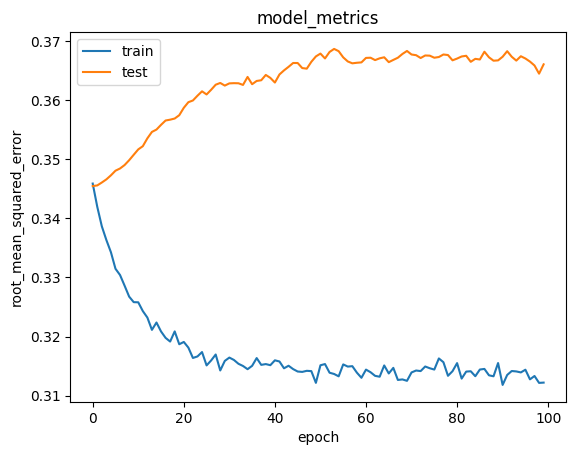

In [73]:
plt.plot(history.history['root_mean_squared_error'])
plt.plot(history.history['val_root_mean_squared_error'])
plt.title('model_metrics')
plt.ylabel('root_mean_squared_error')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

Sebelum melakukan prediksi sistem rekomendasi, buat variabel place_not_visited terlebih dahulu  karena daftar place_not_visited inilah yang akan menjadi resto yang direkomendasikan.

In [74]:
place_df = place_new
df = pd.read_csv('tourism_rating.csv')

# Mengambil sample user
user_id = df['User_Id'].sample(1).iloc[0]
place_visited_by_user = df[df['User_Id'] == user_id]

# Operator bitwise (~), bisa diketahui di sini https://docs.python.org/3/reference/expressions.html
place_not_visited = place_df[~place_df['id'].isin(place_visited_by_user['Place_Id'].values)]['id']
place_not_visited = list(
    set(place_not_visited)
    .intersection(set(place_to_place_encoded.keys()))
)

place_not_visited = [[place_to_place_encoded.get(x)] for x in place_not_visited]
user_encoder = user_to_user_encoded.get(user_id)
user_place_array = np.hstack(
    ([[user_encoder]] * len(place_not_visited), place_not_visited)
)

Selanjutnya, lakukan prediksi untuk memperoleh 10 rekomendasi tempat wisata.

In [75]:
ratings = model.predict(user_place_array).flatten()

top_ratings_indices = ratings.argsort()[-10:][::-1]
recommended_place_ids = [
    place_encoded_to_place.get(place_not_visited[x][0]) for x in top_ratings_indices
]

print('Showing recommendations for users: {}'.format(user_id))
print('===' * 9)
print('place with high ratings from user')
print('----' * 8)

top_place_user = (
    place_visited_by_user.sort_values(
        by = 'Place_Ratings',
        ascending=False
    )
    .head(5)['Place_Ratings'].values
)

place_df_rows = place_df[place_df['id'].isin(top_place_user)]
for row in place_df_rows.itertuples():
    print(row.name, ':', row.category)

print('----' * 8)
print('Top 10 place recommendation')
print('----' * 8)

recommended_place = place_df[place_df['id'].isin(recommended_place_ids)]
for row in recommended_place.itertuples():
    print(row.name, ':', row.category)

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
Showing recommendations for users: 43
place with high ratings from user
--------------------------------
Atlantis Water Adventure : Taman Hiburan
--------------------------------
Top 10 place recommendation
--------------------------------
Ledok Sambi : Cagar Alam
Seribu Batu Songgo Langit : Cagar Alam
Pantai Ngobaran : Bahari
Pantai Baron : Bahari
Pasar Kebon Empring Bintaran : Pusat Perbelanjaan
Pintoe Langit Dahromo : Cagar Alam
Green Village Gedangsari : Taman Hiburan
Candi Ijo : Budaya
Indonesia Kaya Park : Taman Hiburan
Wisata Lereng Kelir : Cagar Alam
